# Import packages

In [57]:
from IPython.core.display import clear_output
from os import path
from PIL import Image
from random import randint
from stop_words import get_stop_words
from warnings import warn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import requests
import seaborn as sns
import string
import warnings
import folium
import time
import geocoder
from folium.plugins import HeatMap

warnings.filterwarnings('ignore')

# Data Load

In [36]:
Job_list = pd.read_csv('Job_list_base.CSV', engine='python', encoding='utf-8', index_col=0)

#Some cleaning and manipulation
Job_list['Search_Terms'] = Job_list['Search_Terms'].str.replace('data%20scientist', 'Data Scientist') 
Job_list['Search_Terms'] = Job_list['Search_Terms'].str.replace('business%20intelligence', 'Business Intelligence') 
Job_list['Search_Terms'] = Job_list['Search_Terms'].str.replace('analyst', 'Analyst') 

#Lets seperate the data
Job_list['Job_title_raw'] = Job_list['Texts'].str.split("Sign in;", n = 1, expand = True)[1].str.split(";", n = 1, expand = True)[0]
Job_list['Job_title_man'] = Job_list['Job_title_raw'].str.replace("-", " ").str.replace("/", " ").str.replace("&", " ").str.replace("  ", " ").str.replace("   ", " ")
Job_list['Job_title_man'] = Job_list['Job_title_man'].str.strip()
Job_list['Job_title_man'] = Job_list['Job_title_man'].str.replace(r"\(.*?\)","")

#Company and City
Job_list['Company'] = Job_list['Texts'].str.split("Sign in;", n = 1, expand = True)[1].str.split(";", n = 1, expand = True)[1].str.split(";", n = 1, expand = True)[0]
Job_list['City'] = Job_list['Texts'].str.split("Sign in;", n = 1, expand = True)[1].str.split(";", n = 1, expand = True)[1].str.split(";", n = 1, expand = True)[1].str.split(";", n = 1, expand = True)[0].str.split(",", n = 1, expand = True)[0]
Job_list['City'] = Job_list['City'].str.replace('Frankfurt am Main', 'Frankfurt')
Job_list['City'] = Job_list['City'].str.replace('Frankfurt am Main und Umgebung', 'Frankfurt')
Job_list['City'] = Job_list['City'].str.replace('10405 Berlin', 'Berlin')
Job_list['City'] = Job_list['City'].str.replace('Berlin Area', 'Berlin')
Job_list['City'] = Job_list['City'].str.replace('Berlin und Umgebung', 'Berlin')
Job_list['City'] = Job_list['City'].str.replace('Berlino', 'Berlin')
Job_list['City'] = Job_list['City'].str.replace(' und Umgebung', '')
Job_list['City'] = Job_list['City'].str.replace(' Area', '')
Job_list['City'] = Job_list['City'].str.replace('Frankfurt Am Main', 'Frankfurt')

#Time posted
Job_list['Time_posted'] = Job_list['Texts'].str.split(" ago;", n = 1, expand = True)[0].str[-8:].str.strip('E;').str.strip('d;').str.strip('y;').str.strip('y;').str.strip('nd;').str.strip('a;').str.strip('DE;')

#Applicants
Job_list['Applicants_number'] = Job_list['Texts'].str.split(" ago;", n = 1, expand = True)[1].str.split(";", n = 1, expand = True)[0]
Job_list_out = Job_list['Applicants_number'].loc[Job_list['Applicants_number'].isnull()]
Job_list = Job_list.loc[~Job_list['Applicants_number'].isin(Job_list_out)]

#Description
Job_list['Description'] = Job_list['Texts'].str.split("Report this job;", n = 1, expand = True)[1].str.split(";Seniority level", n = 1, expand = True)[0]
Job_list['Description'] = Job_list['Description'].str.replace("Posted by:;", "")

#Description length
Job_list['Description_words_amount'] = Job_list['Description'].apply(lambda x: len(str(x).split(" ")))
Job_list['Description_len'] = Job_list['Description'].apply(len)

#Seniority Level
Job_list['Seniority_level'] = Job_list['Texts'].str.split("Seniority level;", n = 1, expand = True)[1].str.split(";Employment type", n = 1, expand = True)[0]

#Employment Type
Job_list['Employment_type'] = Job_list['Texts'].str.split("Employment type;", n = 1, expand = True)[1].str.split(";Job function", n = 1, expand = True)[0]

#Job Function
Job_list['First_job_function'] = Job_list['Texts'].str.split("Job function;", n = 1, expand = True)[1].str.split(";Industries", n = 1, expand = True)[0].str.split(";", n = 1, expand = True)[0]

#Industry
Job_list['First_industry'] = Job_list['Texts'].str.split("Industries;", n = 1, expand = True)[1].str.split(";Search for more jobs like this;", n = 1, expand = True)[0].str.split(";", n = 1, expand = True)[0]

#Title contains
Job_list['Title_small'] = Job_list['Job_title_raw'].apply(lambda x: " ".join(x.lower() for x in x.split()))
Job_list['Title_Data_Scientist'] = Job_list['Title_small'].apply(lambda x: 'data scientist' if 'data scientist' in x else None)
Job_list['Title_Business_Intelligence'] = Job_list['Title_small'].apply(lambda x: 'business intelligence' if 'business intelligence' in x else None)
Job_list['Title_Analyst'] = Job_list['Title_small'].apply(lambda x: 'analyst' if 'analyst' in x else None)
cols= ['Title_Data_Scientist', 'Title_Business_Intelligence', 'Title_Analyst']
Job_list['Titles_combined'] = Job_list[cols].apply(lambda x: ', '.join(x.dropna()), axis=1)
Job_list['Titles_combined'] = Job_list['Titles_combined'].apply(lambda x: " ".join(x.capitalize() for x in x.split()))

#Make Job List small
Job_list['Job_title_man'] = Job_list['Job_title_man'].apply(lambda x: " ".join(x.lower() for x in x.split()))
Job_list['Job_title_man'] = Job_list['Job_title_man'].apply(lambda x: " ".join(x.capitalize() for x in x.split()))

Job_list.head()

,Job_Links,Page_Links,Search_Terms,Texts,Job_title_raw,Job_title_man,Company,City,Time_posted,Applicants_number,...,Description_len,Seniority_level,Employment_type,First_job_function,First_industry,Title_small,Title_Data_Scientist,Title_Business_Intelligence,Title_Analyst,Titles_combined
0,https://www.linkedin.com/jobs/view/1573130365/...,https://www.linkedin.com/jobs/search/?geoId=10...,Data Scientist,"function getDfd() {let yFn,nFn;const p=new Pro...",Data Scientist,Data Scientist,Codepan GmbH,Berlin,5 days,31 applicants,...,2300,Entry level,Full-time,Information Technology,Information Technology and Services,data scientist,data scientist,None,None,Data Scientist
1,https://www.linkedin.com/jobs/view/1599153279/...,https://www.linkedin.com/jobs/search/?geoId=10...,Data Scientist,"function getDfd() {let yFn,nFn;const p=new Pro...",Data Scientist (m/f/d),Data Scientist,Free,Berlin,2 weeks,Be among the first 25 applicants,...,3568,Entry level,Full-time,Engineering,Information Technology and Services,data scientist (m/f/d),data scientist,None,None,Data Scientist
2,https://www.linkedin.com/jobs/view/1612674675/...,https://www.linkedin.com/jobs/search/?geoId=10...,Data Scientist,"function getDfd() {let yFn,nFn;const p=new Pro...",DATA SCIENTIST (M / F),Data Scientist,ixto GmbH,Berlin,1 week,45 applicants,...,1709,Entry level,Part-time,Engineering,Information Technology and Services,data scientist (m / f),data scientist,None,None,Data Scientist
3,https://www.linkedin.com/jobs/view/1569894808/...,https://www.linkedin.com/jobs/search/?geoId=10...,Data Scientist,"function getDfd() {let yFn,nFn;const p=new Pro...",Data Scientist (m/f/d),Data Scientist,Roche,Penzberg,3 weeks,Be among the first 25 applicants,...,5584,Entry level,Full-time,Engineering,Hospital & Health Care,data scientist (m/f/d),data scientist,None,None,Data Scientist
4,https://www.linkedin.com/jobs/view/1524827163/...,https://www.linkedin.com/jobs/search/?geoId=10...,Data Scientist,"function getDfd() {let yFn,nFn;const p=new Pro...",Data Scientist,Data Scientist,Babbel,Berlin,4 weeks,Over 200 applicants,...,3591,Entry level,Full-time,Information Technology,E-Learning,data scientist,data scientist,None,None,Data Scientist


In [4]:
Job_list.to_csv('Job_list_man.CSV',sep=',')

# Exploratory Data Analysis

## Amount

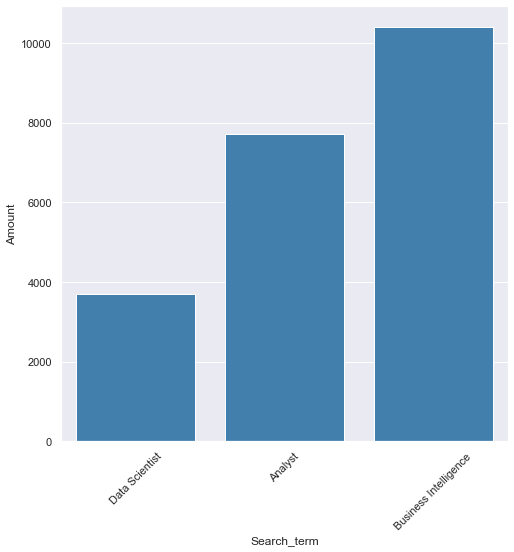

In [4]:
#Simple amount
Search_term=["Data Scientist","Business Intelligence","Analyst"]
Amount=[3684,10397,7720]
df = pd.DataFrame(dict(Search_term=Search_term, Amount=Amount))
df=df.sort_values('Amount', ascending=True).reset_index(drop="True")


sns.set(font_scale = 4)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 10})
plt.figure(figsize=(8,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
ax= sns.barplot(x="Search_term",y="Amount", data=df, color = "#3182bd", ci=None)
ax.set(ylim=(0))
plt.show()

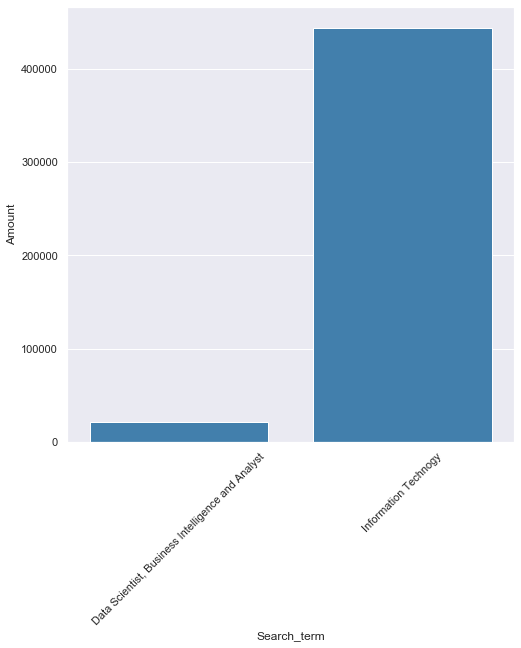

In [5]:
#Simple amount
Search_term=["Data Scientist, Business Intelligence and Analyst","Information Technogy"]
Amount=[21801,444170]
df = pd.DataFrame(dict(Search_term=Search_term, Amount=Amount))
df=df.sort_values('Amount', ascending=True).reset_index(drop="True")


sns.set(font_scale = 4)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 10})
plt.figure(figsize=(8,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
ax= sns.barplot(x="Search_term",y="Amount", data=df, color = "#3182bd", ci=None)
ax.set(ylim=(0))
plt.show()

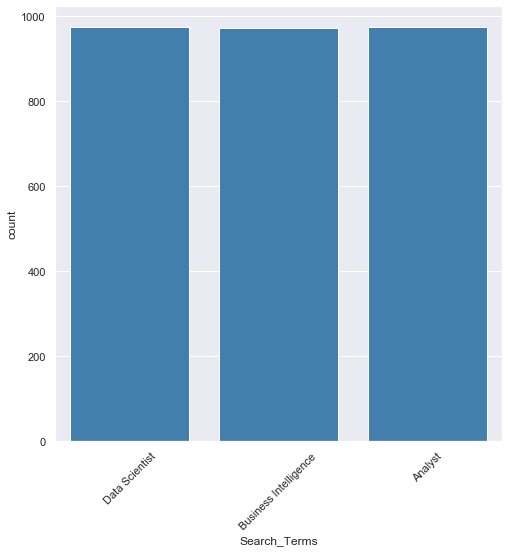

In [6]:
sns.set(font_scale = 4)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 10})
plt.figure(figsize=(8,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
ax= sns.countplot("Search_Terms", data=Job_list, color = "#3182bd")
ax.set(ylim=(0))
plt.show()

## Job Title

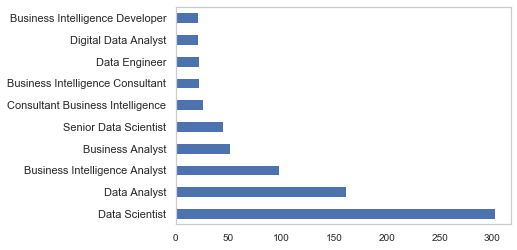

In [7]:
plt.tick_params(axis="x", labelsize=10)
Job_list.Job_title_man.value_counts().sort_values(ascending=False)[:10].plot(kind="barh")
plt.xticks(rotation=0)
plt.show()

In [8]:
grouped = pd.crosstab(Job_list.Job_title_man, Job_list.Search_Terms)
grouped["Total"] = grouped["Analyst"] + grouped["Business Intelligence"] + grouped["Data Scientist"]
grouped = grouped.sort_values('Total', ascending=False)
grouped[:10]

Search_Terms,Analyst,Business Intelligence,Data Scientist,Total
Job_title_man,,,,
Data Scientist,4,39,259,302
Data Analyst,89,18,54,161
Business Intelligence Analyst,38,60,0,98
Business Analyst,36,15,0,51
Senior Data Scientist,0,2,43,45
Consultant Business Intelligence,0,26,0,26
Data Engineer,1,20,1,22
Business Intelligence Consultant,0,22,0,22
Business Intelligence Developer,0,21,0,21


## Overlap count

In [9]:
grouped = pd.crosstab(Job_list.Titles_combined, Job_list.Search_Terms)
grouped["Total"] = grouped["Analyst"] + grouped["Business Intelligence"] + grouped["Data Scientist"]
grouped = grouped.sort_values('Total', ascending=False)
grouped

Search_Terms,Analyst,Business Intelligence,Data Scientist,Total
Titles_combined,,,,
Analyst,868,155,138,1161
Data Scientist,7,96,715,818
Business Intelligence,4,417,3,424
,25,162,98,285
"Business Intelligence, Analyst",70,133,6,209
"Data Scientist, Analyst",1,5,12,18
"Data Scientist, Business Intelligence",0,2,2,4
"Data Scientist, Business Intelligence, Analyst",0,3,1,4


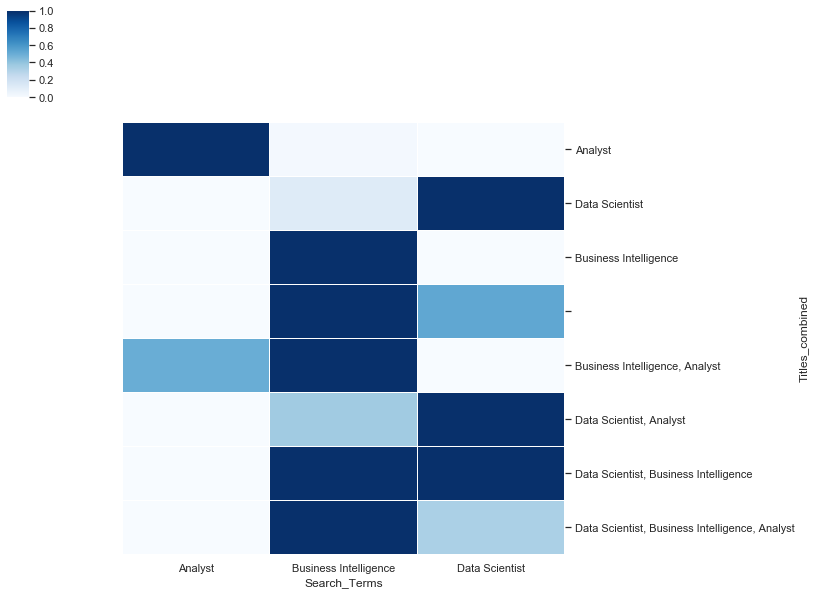

In [10]:
grouped = grouped.iloc[:, 0:3]
sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0, col_cluster=False, row_cluster=False)

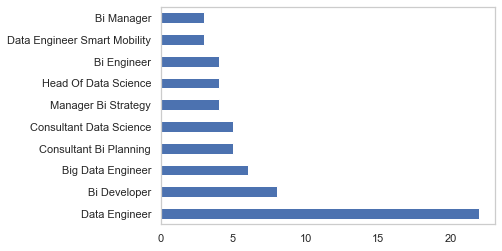

In [11]:
Job_list[Job_list['Titles_combined']==''].Job_title_man.value_counts().sort_values(ascending=False)[:10].plot(kind="barh")
plt.show()

## Company

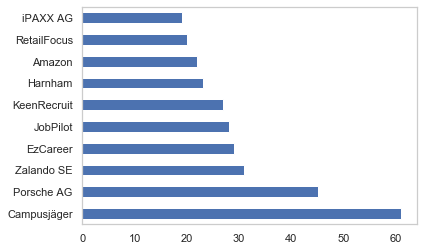

In [12]:
Job_list.Company.value_counts().sort_values(ascending=False)[:10].plot(kind="barh")
plt.show()

In [13]:
grouped = pd.crosstab(Job_list.Company, Job_list.Search_Terms)
grouped["Total"] = grouped["Analyst"] + grouped["Business Intelligence"] + grouped["Data Scientist"]
grouped = grouped.sort_values('Total', ascending=False)
grouped[:10]

Search_Terms,Analyst,Business Intelligence,Data Scientist,Total
Company,,,,
Campusjäger,4,28,29,61
Porsche AG,6,29,10,45
Zalando SE,9,10,12,31
EzCareer,24,3,2,29
JobPilot,22,4,2,28
KeenRecruit,20,5,2,27
Harnham,9,6,8,23
Amazon,8,8,6,22
RetailFocus,15,3,2,20


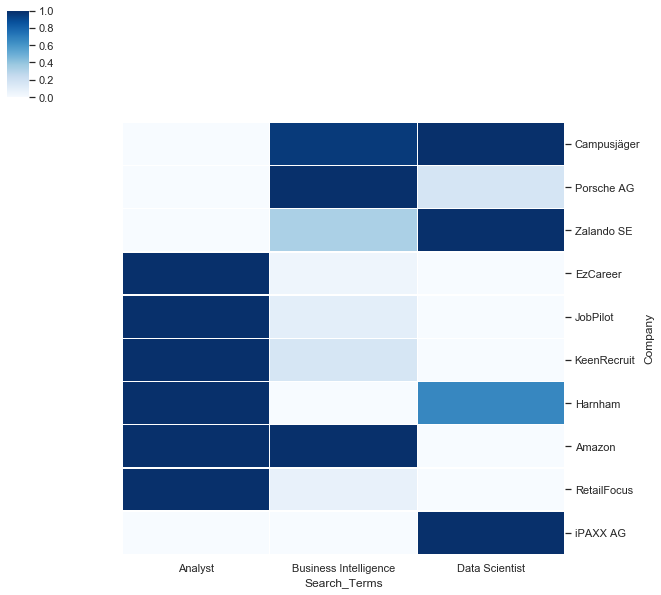

In [14]:
grouped = grouped.iloc[:, 0:3]
sns.clustermap(grouped[:10], cmap="Blues", linewidth=.5, standard_scale=0, col_cluster=False, row_cluster=False)

## City

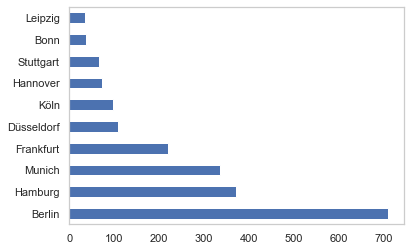

In [15]:
Job_list.City.value_counts().sort_values(ascending=False)[:10].plot(kind="barh")
plt.show()

In [16]:
grouped = pd.crosstab(Job_list.City, Job_list.Search_Terms)
grouped["Total"] = grouped["Analyst"] + grouped["Business Intelligence"] + grouped["Data Scientist"]
grouped = grouped.sort_values('Total', ascending=False)
grouped[:10]

Search_Terms,Analyst,Business Intelligence,Data Scientist,Total
City,,,,
Berlin,253,234,224,711
Hamburg,146,109,117,372
Munich,110,115,110,335
Frankfurt,108,50,62,220
Düsseldorf,41,39,29,109
Köln,45,27,25,97
Hannover,16,25,31,72
Stuttgart,17,23,27,67
Bonn,4,9,24,37


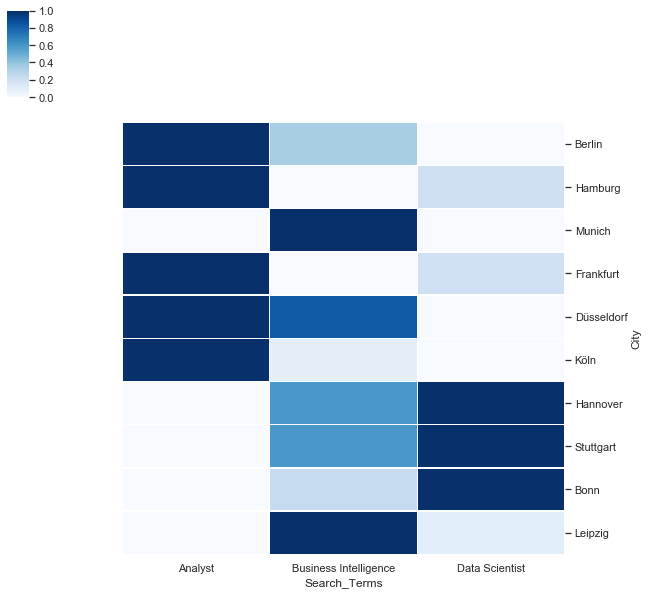

In [17]:
grouped = grouped.iloc[:, 0:3]
sns.clustermap(grouped[:10], cmap="Blues", linewidth=.5, standard_scale=0, col_cluster=False, row_cluster=False)

### Map

In [37]:
list_lat = []   # create empty lists
list_long = []

for index, row in Job_list.iterrows(): # iterate over rows in dataframe

    City = row['City']
    query = str(City)

    results = geocoder.bing(query, key='nReoYlSyKa7bNHrfvhOk~s1o5LKAt0EeGB2uzWDatEA~AornPa_MxwI60LoAy6YjXLKEswPz7eeVch1lNGVaAMlFQVxtIrfbSntFSCWRtK_J')   
    lat = results.lat
    long = results.lng

    list_lat.append(lat)
    list_long.append(long)

# create new columns from lists    

Job_list['City_lat'] = list_lat   
Job_list['City_lon'] = list_long

In [39]:
Job_list.to_csv('Job_list_man.CSV',sep=',')

In [67]:
#All
Job_list_clean=Job_list.dropna(subset=['City_lat'])
Job_list_clean=Job_list_clean.dropna(subset=['City_lon'])
base_map = folium.Map(location=[51.1633987,10.4468737], zoom_start=10)
Job_list_clean = Job_list_clean.groupby(['City_lat', 'City_lon']).count().reset_index()
HeatMap(data=Job_list_clean[['City_lat', 'City_lon', 'Job_Links']], radius=15, max_zoom=13).add_to(base_map)
base_map

In [65]:
#Only Analyst
Job_list_clean=Job_list.dropna(subset=['City_lat'])
Job_list_clean=Job_list_clean.dropna(subset=['City_lon'])
Job_list_clean = Job_list_clean[Job_list_clean.Search_Terms == "Analyst"]
base_map = folium.Map(location=[51.1633987,10.4468737], zoom_start=10)
Job_list_clean = Job_list_clean.groupby(['City_lat', 'City_lon']).count().reset_index()
HeatMap(data=Job_list_clean[['City_lat', 'City_lon', 'Job_Links']], radius=20, max_zoom=13).add_to(base_map)
base_map

In [66]:
#Only Business Intelligence
Job_list_clean=Job_list.dropna(subset=['City_lat'])
Job_list_clean=Job_list_clean.dropna(subset=['City_lon'])
Job_list_clean = Job_list_clean[Job_list_clean.Search_Terms == "Business Intelligence"]
base_map = folium.Map(location=[51.1633987,10.4468737], zoom_start=10)
Job_list_clean = Job_list_clean.groupby(['City_lat', 'City_lon']).count().reset_index()
HeatMap(data=Job_list_clean[['City_lat', 'City_lon', 'Job_Links']], radius=20, max_zoom=13).add_to(base_map)
base_map

In [61]:
#Only Data Scientist
Job_list_clean=Job_list.dropna(subset=['City_lat'])
Job_list_clean=Job_list_clean.dropna(subset=['City_lon'])
Job_list_clean = Job_list_clean[Job_list_clean.Search_Terms == "Data Scientist"]
base_map = folium.Map(location=[51.1633987,10.4468737], zoom_start=10)
Job_list_clean = Job_list_clean.groupby(['City_lat', 'City_lon']).count().reset_index()
HeatMap(data=Job_list_clean[['City_lat', 'City_lon', 'Job_Links']], radius=20, max_zoom=13).add_to(base_map)
base_map

## Time posted

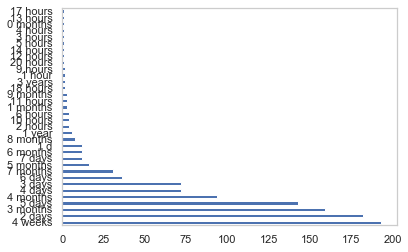

In [19]:
Job_list.Time_posted.value_counts().sort_values(ascending=False)[5:].plot(kind="barh")
plt.show()

In [20]:
grouped = pd.crosstab(Job_list.Time_posted, Job_list.Search_Terms)
grouped["Total"] = grouped["Analyst"] + grouped["Business Intelligence"] + grouped["Data Scientist"]
grouped = grouped.sort_values('Total', ascending=False)
grouped[:20]

Search_Terms,Analyst,Business Intelligence,Data Scientist,Total
Time_posted,,,,
2 weeks,222,219,180,621
2 months,113,129,144,386
3 weeks,100,106,98,304
1 week,96,81,95,272
1 month,73,95,86,254
4 weeks,62,65,66,193
2 days,64,50,68,182
3 months,40,63,56,159
5 days,76,34,33,143


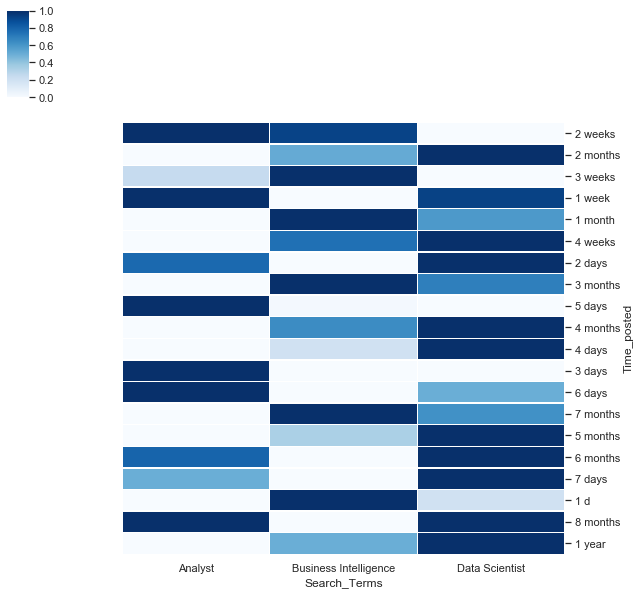

In [21]:
grouped = grouped.iloc[:, 0:3]
sns.clustermap(grouped[:20], cmap="Blues", linewidth=.5, standard_scale=0, col_cluster=False, row_cluster=False)

## Applicants

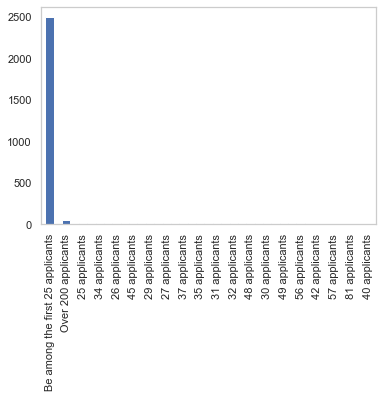

In [22]:
Job_list.Applicants_number.value_counts().sort_values(ascending=False)[:20].plot(kind="bar")
plt.show()

In [23]:
grouped = pd.crosstab(Job_list.Applicants_number, Job_list.Search_Terms)
grouped["Total"] = grouped["Analyst"] + grouped["Business Intelligence"] + grouped["Data Scientist"]
grouped = grouped.sort_values('Total', ascending=False)
grouped[:20]

Search_Terms,Analyst,Business Intelligence,Data Scientist,Total
Applicants_number,,,,
Be among the first 25 applicants,804,867,828,2499
Over 200 applicants,15,11,24,50
25 applicants,6,6,5,17
34 applicants,5,1,7,13
26 applicants,5,5,3,13
45 applicants,3,4,3,10
37 applicants,3,3,3,9
27 applicants,5,2,2,9
29 applicants,4,4,1,9


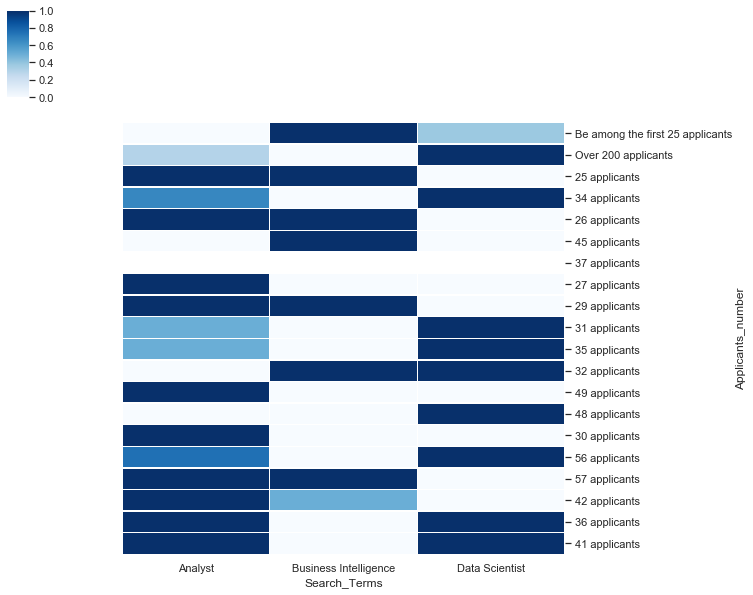

In [24]:
grouped = grouped.iloc[:, 0:3]
sns.clustermap(grouped[:20], cmap="Blues", linewidth=.5, standard_scale=0, col_cluster=False, row_cluster=False)

## Seniority level

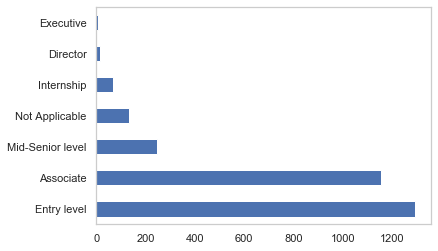

In [26]:
Job_list.Seniority_level.value_counts().sort_values(ascending=False)[:20].plot(kind="barh")
plt.show()

In [27]:
grouped = pd.crosstab(Job_list.Seniority_level, Job_list.Search_Terms)
grouped["Total"] = grouped["Analyst"] + grouped["Business Intelligence"] + grouped["Data Scientist"]
grouped = grouped.sort_values('Total', ascending=False)
grouped

Search_Terms,Analyst,Business Intelligence,Data Scientist,Total
Seniority_level,,,,
Entry level,371,298,624,1293
Associate,469,504,182,1155
Mid-Senior level,65,79,103,247
Not Applicable,54,43,36,133
Internship,13,31,26,70
Director,3,12,2,17
Executive,0,6,2,8


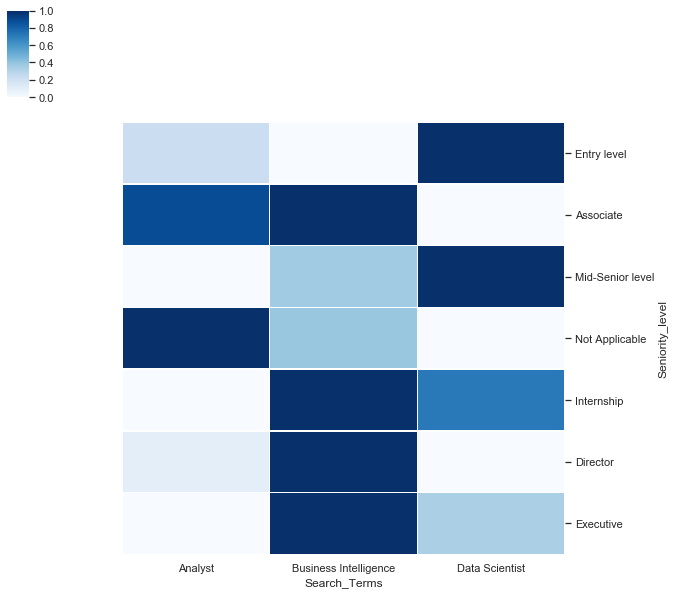

In [28]:
grouped = grouped.iloc[:, 0:3]
sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0, col_cluster=False, row_cluster=False)

## Employment type

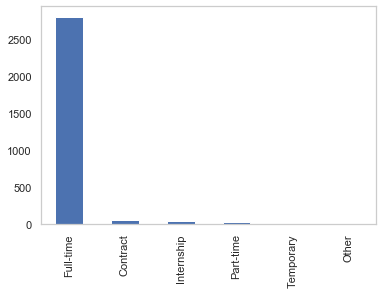

In [344]:
Job_list.Employment_type.value_counts().sort_values(ascending=False)[:20].plot(kind="bar")
plt.show()

In [345]:
grouped = pd.crosstab(Job_list.Employment_type, Job_list.Search_Terms)
grouped["Total"] = grouped["Analyst"] + grouped["Business Intelligence"] + grouped["Data Scientist"]
grouped = grouped.sort_values('Total', ascending=False)
grouped

Search_Terms,Analyst,Business Intelligence,Data Scientist,Total
Employment_type,,,,
Full-time,927,943,937,2807
Contract,21,12,12,45
Internship,11,15,14,40
Part-time,13,3,12,28
Temporary,2,0,0,2
Other,1,0,0,1


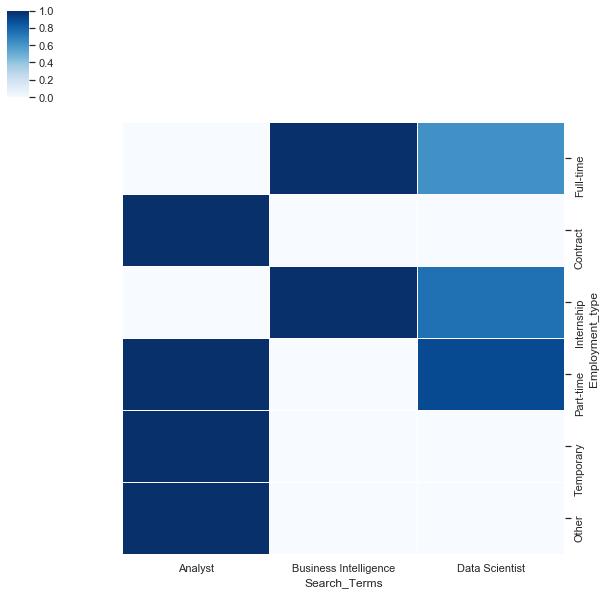

In [346]:
grouped = grouped.iloc[:, 0:3]
sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0, col_cluster=False, row_cluster=False)

## Job function - first mention

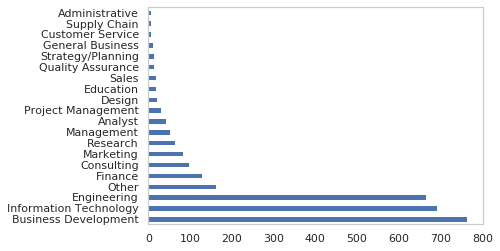

In [65]:
Job_list.First_job_function.value_counts().sort_values(ascending=False)[:20].plot(kind="barh")
plt.show()

In [67]:
grouped = pd.crosstab(Job_list.First_job_function, Job_list.Search_Terms)
grouped["Total"] = grouped["Analyst"] + grouped["Business Intelligence"] + grouped["Data Scientist"]
grouped = grouped.sort_values('Total', ascending=False)
grouped[:20]

Search_Terms,Analyst,Business Intelligence,Data Scientist,Total
First_job_function,,,,
Business Development,309,439,16,764
Information Technology,256,190,246,692
Engineering,14,110,540,664
Other,34,35,93,162
Finance,121,7,0,128
Consulting,10,69,19,98
Marketing,61,18,5,84
Research,38,5,20,63
Management,39,13,0,52


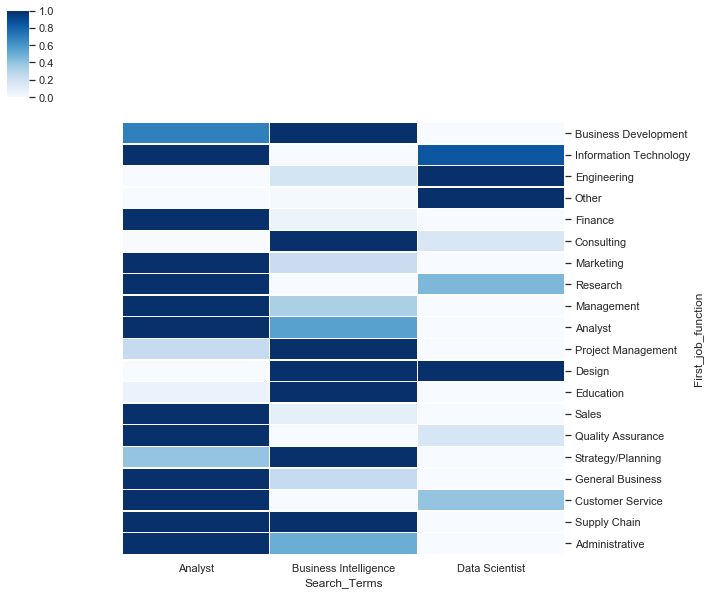

In [349]:
grouped = grouped.iloc[:, 0:3]
sns.clustermap(grouped[:20], cmap="Blues", linewidth=.5, standard_scale=0, col_cluster=False, row_cluster=False)

## Industry - First Mention

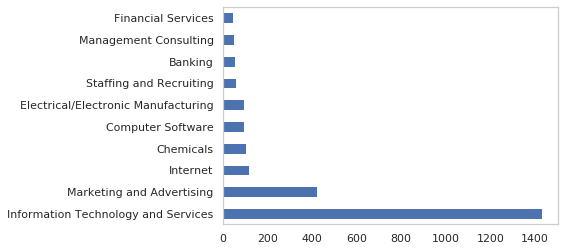

In [69]:
Job_list.First_industry.value_counts().sort_values(ascending=False)[:10].plot(kind="barh")
plt.show()

In [351]:
grouped = pd.crosstab(Job_list.First_industry, Job_list.Search_Terms)
grouped["Total"] = grouped["Analyst"] + grouped["Business Intelligence"] + grouped["Data Scientist"]
grouped = grouped.sort_values('Total', ascending=False)
grouped[:20]

Search_Terms,Analyst,Business Intelligence,Data Scientist,Total
First_industry,,,,
Information Technology and Services,348,529,555,1432
Marketing and Advertising,170,132,122,424
Internet,41,39,36,116
Chemicals,65,14,26,105
Computer Software,31,32,31,94
Electrical/Electronic Manufacturing,32,29,32,93
Staffing and Recruiting,21,14,25,60
Banking,42,9,2,53
Management Consulting,17,18,15,50


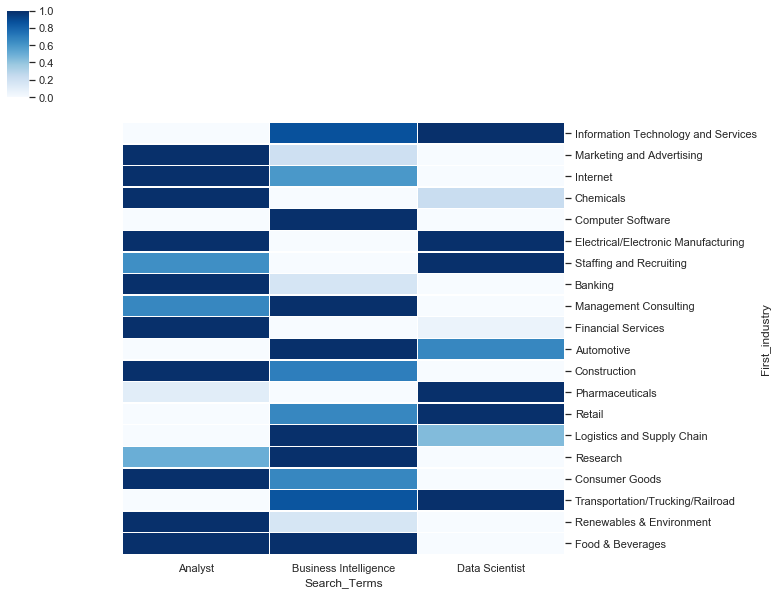

In [352]:
grouped = grouped.iloc[:, 0:3]
sns.clustermap(grouped[:20], cmap="Blues", linewidth=.5, standard_scale=0, col_cluster=False, row_cluster=False)

## Wordmap

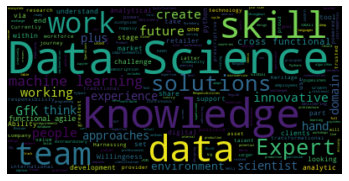

In [71]:
# Start with one review:
text = Job_list['Description'][5]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [72]:
text = " ".join(text for text in Job_list['Description'])
print ("There are {} words in the combination of all descriptions.".format(len(text)))

There are 7972772 words in the combination of all descriptions.


In [73]:
from stop_words import get_stop_words
stop_words_de = get_stop_words('de')

There are 2703549 words in the combination of all descriptions.


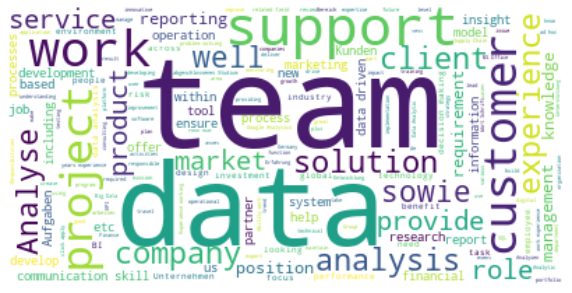

In [76]:
Job_list_Analyst = Job_list[Job_list.Search_Terms=='Analyst']
text = " ".join(text for text in Job_list_Analyst['Description'])
print ("There are {} words in the combination of all descriptions.".format(len(text)))
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Scientist", "Business", "Intelligence", "Analyst", "Science"])
stopwords.update(stop_words_de)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize=[10,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 2606532 words in the combination of all descriptions.


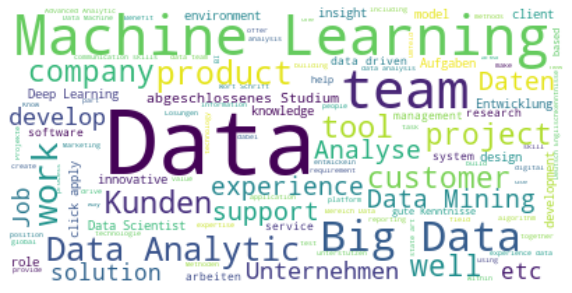

In [77]:
Job_list_Analyst = Job_list[Job_list.Search_Terms=='Data Scientist']
text = " ".join(text for text in Job_list_Analyst['Description'])
print ("There are {} words in the combination of all descriptions.".format(len(text)))
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Scientist", "Business", "Intelligence", "Analyst", "Science","sowie"])
stopwords.update(stop_words_de)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize=[10,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 2662689 words in the combination of all descriptions.


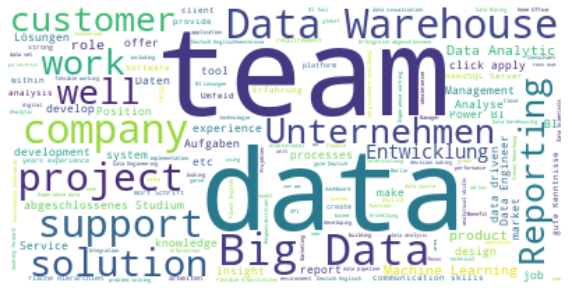

In [78]:
Job_list_Analyst = Job_list[Job_list.Search_Terms=='Business Intelligence']
text = " ".join(text for text in Job_list_Analyst['Description'])
print ("There are {} words in the combination of all descriptions.".format(len(text)))
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Scientist", "Business", "Intelligence", "Analyst", "Science","sowie"])
stopwords.update(stop_words_de)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize=[10,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Description length

In [75]:
grouped = Job_list.groupby('Search_Terms').mean()
grouped

,Description_words_amount,Description_len
Search_Terms,,
Analyst,358.673846,2771.871795
Business Intelligence,339.156218,2735.577595
Data Scientist,334.438974,2672.367179
